In [6]:
# %load defaults.ipy
# %load defaults.ipy
import sys
for p in sys.path:
    if 'netcdf' in p.lower():
        sys.path.remove(p)
    if 'matplotlib' in p.lower():
        sys.path.remove(p)
from numpy import *
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 200
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4
from IPython.core.display import display, HTML
import matplotlib2tikz
import PIL



def writeMetadata(filename, data):
    im = PIL.Image.open(filename)
    
    meta = PIL.PngImagePlugin.PngInfo()

    for key in data.keys():
        meta.add_text(key, data[key])
    im.save(filename, "png", pnginfo=meta)
    
def showAndSave(name):
    fig = plt.gcf()
    ax = plt.gca()
    ax.text(0.95, 0.01, 'By Kjetil Olsen Lye\nkjetil.o.lye@gmail.com',
         fontsize=3, color='gray',
         ha='right', va='bottom', alpha=0.5, transform=ax.transAxes)

    matplotlib2tikz.save(name + '.tikz',
           figureheight = '\\figureheight',
           figurewidth = '\\figurewidth')
    
    savenamepng = name + '.png'
    plt.savefig(savenamepng)
    
    writeMetadata(savenamepng, {'Copyright' : 'Copyright, Kjetil Olsen Lye kjetil.o.lye@gmail.com'
                               })
    plt.show()
    
def legendLeft():
    ax = plt.gca()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [8]:
import sys
sys.path.append("/cluster/home/klye/alsvinn/build/python/")
sys.path.append("/home/kjetil/projects/alsvinn/build/python/")
import alsvinn

# Wasserstein distance computation

In [14]:
import ot
def wasserstein_point2(data1, data2, i, j, a, b, xs, xt):
    """
    Computes the Wasserstein distance for a single point in the spatain domain
    """
    

    xs[:,0] = data1[i,:]
    xs[:,1] = data1[j,:]

    xt[:,0] = data2[i,:]
    xt[:,1] = data2[j,:]

    M = ot.dist(xs, xt, metric='euclidean')
    G0 = ot.emd(a,b,M)

    return sum(G0*M)

def wasserstein2pt(data1, data2):
    """
    Approximate the L^1(W_1) distance (||W_1(nu1, nu2)||_{L^1})
    """
    M = data1.shape[1]
    a = ones(M)/M
    b = ones(M)/M
    xs = zeros((M,2))
    xt = zeros((M,2))
    N = data1.shape[0]
    distance = 0
    
    for i in range(N):
        for j in range(N):
            distance += wasserstein_point2(data1, data2, i, j, a, b, xs, xt)

    
    return distance / N**2


def plotWasserstein2ptConvergenceCauchy(config, name, r, Ms,t):
    wasserstein2pterrors = []
    for (nm, M) in enumerate(Ms[:-1]):
        
        data1 = zeros((r, 2*M))
        data2 = zeros((r, 2*M))
        for k in range(M):
            data1[:,2*k] = config.get_data('u', timestep=t, sample=k)
            data1[:,2*k+1] = config.get_data('u', timestep=t, sample=k)
            
            data2[:,2*k] = config.get_data('u', timestep=t, sample=2*k)
            data2[:,2*k+1] = config.get_data('u', timestep=t, sample=2*k+1)

        wasserstein2pterrors.append(wasserstein2pt(data1, data2))
        print("wasserstein2pterrorscauchy=%s" % wasserstein2pterrors)
    

    plt.loglog(Ms[1:], wasserstein2pterrors, '-o',label=name)
    poly = polyfit(log(Ms[1:]), log(wasserstein2pterrors),1)
    plt.loglog(Ms[1:], exp(poly[1])*Ms[1:]**poly[0], '--', label='$O(M^{%.3f})$' % poly[0])
    plt.xlabel("$M$")
    plt.ylabel('$||W_1(\\nu^{2, \\Delta x, M}, \\nu^{2,\\Delta x, 2M})||_{L^1(D\\times D)}$')
    plt.title("Wasserstein Cauchy convergence for %s\nfor second correlation measure,\nwith respect to $M$" %(name))

def plotWasserstein2ptConvergence(config, name, r, Ms, t):
    wasserstein2pterrors = []
    for (nm, M) in enumerate(Ms[:-1]):
        
        data1 = zeros((r, Ms[-1]))
        data2 = zeros((r, Ms[-1]))
        factor = Ms[-1]//M
        for k in range(M):
            for kp in range(factor):
                data1[:,factor*k + kp] = config.get_data('u', timestep=t, sample=k)
                data2[:,factor*k+kp] = config.get_data('u', timestep=t, sample=factor*k+kp)
                

        wasserstein2pterrors.append(wasserstein2pt(data1, data2))
        print("wasserstein2pterrors=%s" % wasserstein2pterrors)
    

    plt.loglog(Ms[1:], wasserstein2pterrors, '-o',label=name)
    poly = polyfit(log(Ms[1:]), log(wasserstein2pterrors),1)
    plt.loglog(Ms[1:], exp(poly[1])*Ms[1:]**poly[0], '--', label='$O(M^{%.3f})$' % poly[0])
    plt.xlabel("$M$")
    plt.ylabel('$||W_1(\\nu^{2, \\Delta x, M}, \\nu^{2,\\Delta x, M_0})||_{L^1(D\\times D)}$')
    plt.title("Wasserstein convergence for %s\nfor second correlation measure,\nwith respect to $M$\nagainst reference solution with $M_0=%d$" %(name, Ms[-1]))
    

In [15]:
import ot
def wasserstein_point(data1, data2, i, a, b, xs, xt):
    """
    Computes the Wasserstein distance for a single point in the spatain domain
    """
    

    xs[:,0] = data1[i,:]

    xt[:,0] = data2[i,:]

    M = ot.dist(xs, xt, metric='euclidean')
    G0 = ot.emd(a,b,M)

    return sum(G0*M)

def wasserstein(data1, data2):
    """
    Approximate the L^1(W_1) distance (||W_1(nu1, nu2)||_{L^1})
    """
    M = data1.shape[1]
    a = ones(M)/M
    b = ones(M)/M
    xs = zeros((M,1))
    xt = zeros((M,1))
    N = data1.shape[0]
    distance = 0
    
    for i in range(N):
        distance += wasserstein_point(data1, data2, i, a, b, xs, xt)

    
    return distance / N


def plotWassersteinConvergenceCauchy(config, name, r, Ms, t):
    wassersteinerrors = []
    for (nm, M) in enumerate(Ms[:-1]):
        
        data1 = zeros((r, 2*M))
        data2 = zeros((r, 2*M))
        for k in range(M):
            data1[:,2*k] = config.get_data('u', timestep=t, sample=k)
            data1[:,2*k+1] = config.get_data('u', timestep=t, sample=k)
            
            data2[:,2*k] = config.get_data('u', timestep=t, sample=2*k)
            data2[:,2*k+1] = config.get_data('u', timestep=t, sample=2*k+1)

        wassersteinerrors.append(wasserstein(data1, data2))
        print("wassersteinerrorscauchy=%s" % wassersteinerrors)
    

    plt.loglog(Ms[1:], wassersteinerrors, '-o',label=name)
    poly = polyfit(log(Ms[1:]), log(wassersteinerrors),1)
    plt.loglog(Ms[1:], exp(poly[1])*Ms[1:]**poly[0], '--', label='$O(M^{%.3f})$' % poly[0])
    plt.xlabel("$M$")
    plt.ylabel('$||W_1(\\nu^{1, \\Delta x, M}, \\nu^{1,\\Delta x, 2M})||_{L^1(D)}$')
    plt.title("Wasserstein Cauchy convergence for %s\nfor first correlation measure,\nwith respect to $M$" %(name))

def plotWassersteinConvergence(config, name, r, Ms, t):
    wassersteinerrors = []
    for (nm, M) in enumerate(Ms[:-1]):
        
        data1 = zeros((r, Ms[-1]))
        data2 = zeros((r, Ms[-1]))
        factor = Ms[-1]//M
        for k in range(M):
            for kp in range(factor):
                data1[:,factor*k + kp] = config.get_data('u', timestep=t, sample=k)
                data2[:,factor*k+kp] = config.get_data('u', timestep=t, sample=factor*k+kp)
                

        wassersteinerrors.append(wasserstein(data1, data2))
        print("wassersteinerrors=%s" % wassersteinerrors)
    

    plt.loglog(Ms[1:], wassersteinerrors, '-o',label=name)
    poly = polyfit(log(Ms[1:]), log(wassersteinerrors),1)
    plt.loglog(Ms[1:], exp(poly[1])*Ms[1:]**poly[0], '--', label='$O(M^{%.3f})$' % poly[0])
    plt.xlabel("$M$")
    plt.ylabel('$||W_1(\\nu^{1, \\Delta x, M}, \\nu^{1,\\Delta x, M_0})||_{L^1(D)}$')
    plt.title("Wasserstein convergence for %s\nfor first correlation measure,\nwith respect to $M$\nagainst reference solution with $M_0=%d$" %(name, Ms[-1]))
    

In [13]:
import re
def computeConvergence(basename, showSingle=False):
    if 'sine_' in basename:
        name = re.search(r'sine_(.+)\/', basename).group(1)
    else:
        name = re.search(r'brownian_(.+)\/', basename).group(1)
    print(basename)
    name = name.replace("_", " ").title()
    
    N = 128
    display(HTML("<h1>%s</h1>" % name))
    try:
        r = alsvinn.run(name='test', base_xml=basename, dimension=[N,1,1], uq=True, samples=4096)
    except Exception as e:
        print("%s failed, see error message below: " % name)
        print (e)
        return
    Ms = 2**array(range(3,13))
    
    for t in [0,1]:
        plt.figure(t)
        errors = []
        for M in Ms:
            mean = zeros((N))
            for k in range(M):
                mean += r.get_data('u', timestep=t, sample=k)
            mean /= M
            
            if M > Ms[0]:
                errors.append(sqrt(sum(abs(mean-meanPrev)**2)/mean.shape[0]))
            meanPrev = mean
            if showSingle:
                x = linspace(0,1,N)
                plt.plot(x,mean)
                plt.ylabel('$\mathbb{E}(u(x,%d))$' % t)
                plt.xlabel('$x$')
                plt.title('$M=%d$' % M)
                plt.show()
        plt.loglog(Ms[:-1], errors, '-o',label=name)
        poly = polyfit(log(Ms[1:]), log(errors), 1)
        
        plt.loglog(Ms, exp(poly[1])*Ms**poly[0], '--', label='$O(M^{%.3f})$' % poly[0])
        plt.xlabel("M")
        plt.ylabel("Error")
        
        if not showSingle:
            plt.title("Cauchy convergence at $T=%d$ (normalized time)" % t)
        legendLeft()
        if showSingle:
            
            plt.title("Cauchy Convergence for %s at $T=%d$ (normalized time)" % (name,t))
            plt.show()
    
    for t in [0,1]:
        errors = []
        plt.figure(2+t)
        referenceSolution = zeros((N))
        for k in range(Ms[-1]):
            referenceSolution += r.get_data('u', timestep=t, sample=k)
        referenceSolution /= Ms[-1]
        for M in Ms[:-1]:
            mean = zeros((N))
            for k in range(M):
                mean += r.get_data('u', timestep=t, sample=k)
            mean /= M
            
            
            errors.append(sqrt(sum(abs(mean-referenceSolution)**2)/mean.shape[0]))
           
        plt.loglog(Ms[:-1], errors, '-o',label=name)
        poly = polyfit(log(Ms[1:]), log(errors), 1)
        
        plt.loglog(Ms, exp(poly[1])*Ms**poly[0], '--', label='$O(M^{%.3f})$' % poly[0])
        plt.xlabel("M")
        plt.ylabel("Error")
        if not showSingle:
            plt.title("Convergence against reference solution\n$T=%d$ (normalized time)" % t)
        
        legendLeft()
        if showSingle:
            plt.title("Convergence for %s at $T=%d$ (normalized time)\nagainst reference solution" % (name,t))
            plt.show()
    for t in [0,1]:
        plt.figure(4+t)
        plotWasserstein2ptConvergence(r, name, N, Ms, t)
        legendLeft()
        if showSingle:
            plt.show()
        plt.figure(6+t)
        plotWasserstein2ptConvergenceCauchy(r, name, N, Ms, t)
        legendLeft()
        if showSingle:
            plt.show()
        
        plt.figure(8+t)
        plotWassersteinConvergence(r, name, N, Ms,t)
        legendLeft()
        if showSingle:
            plt.show()
            
        plt.figure(10+t)
        plotWassersteinConvergenceCauchy(r, name, N, Ms,t)
        legendLeft()
        if showSingle:
            plt.show()

# Smooth initial data

Here we test with some smooth initial data of the form

$$ u_0(\omega,x)=\sum_{n=1}^{10} a_n(x)X_n(\omega)$$

approximating a Gaussian field. Here we have ten dimensions.

In [ ]:
import glob

for basename in glob.glob("../configs/sine_*"):
    computeConvergence(basename + "/sine.xml")

../configs/sine_latin_random/sine.xml


../configs/sine_latin_random/sine.xml


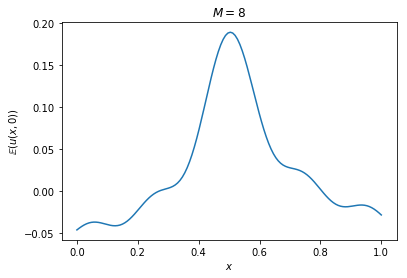

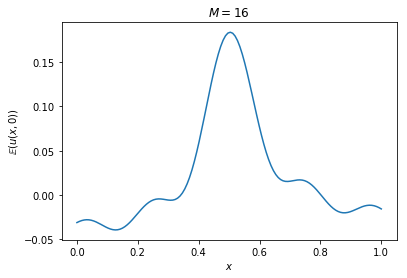

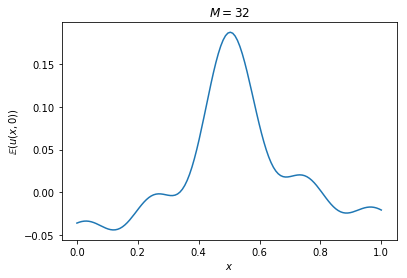

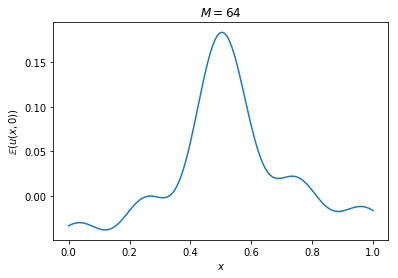

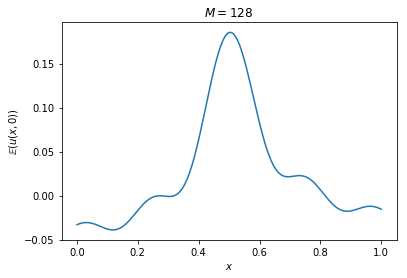

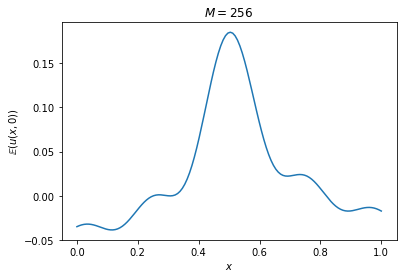

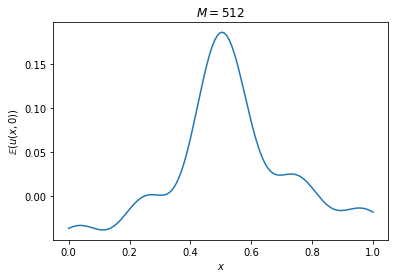

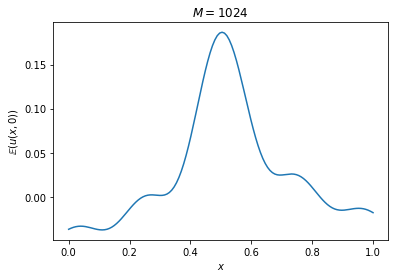

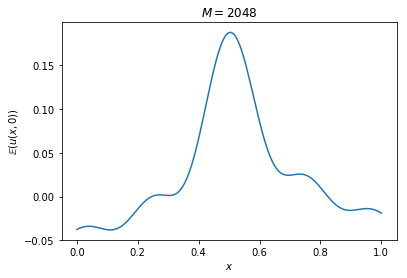

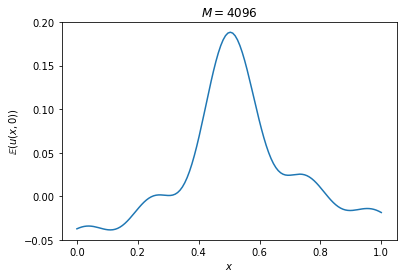

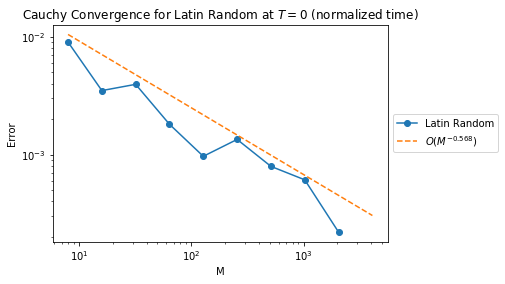

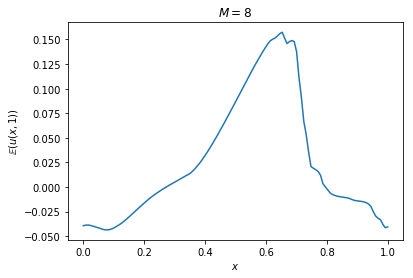

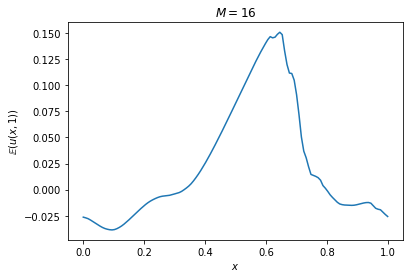

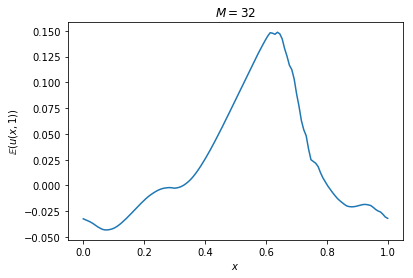

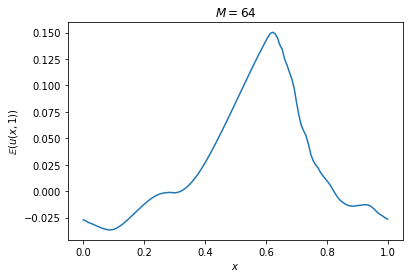

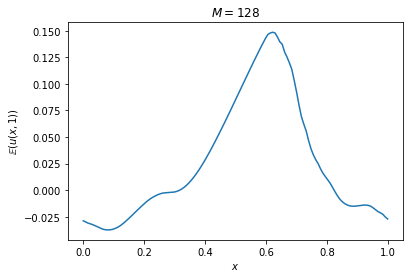

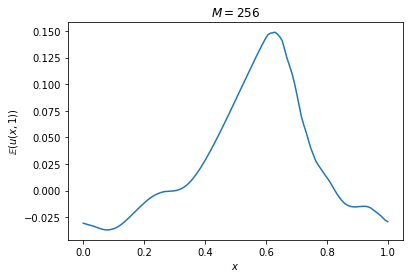

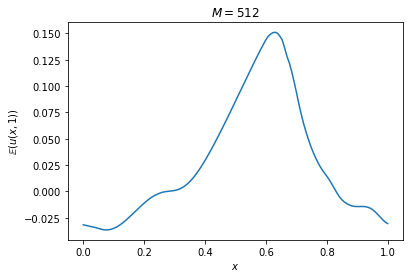

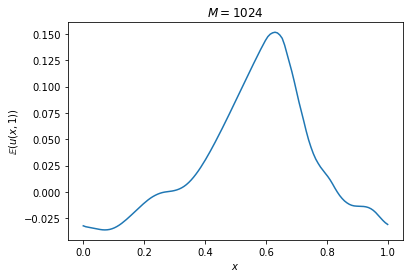

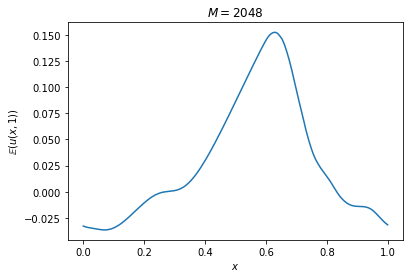

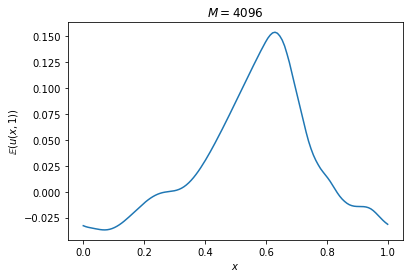

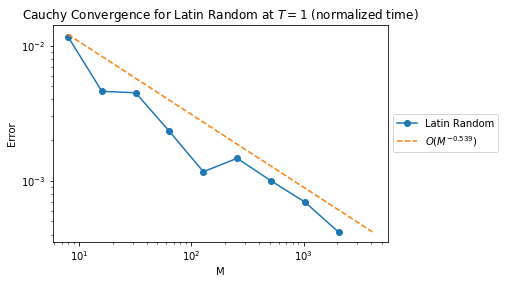

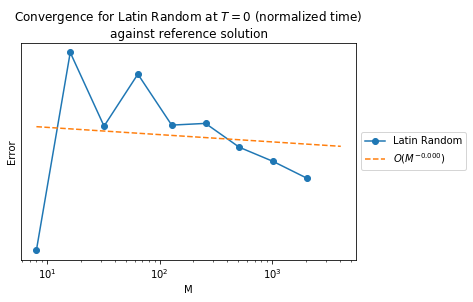

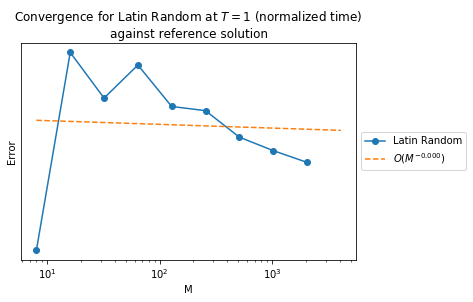

/home/kjetil/.local/lib/python3.6/site-packages/ot/lp/__init__.py:98: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


In [ ]:
import glob

for basename in glob.glob("../configs/sine_*"):
    computeConvergence(basename + "/sine.xml", True)

# Brownian initial data

Here we let the initial data be given as (truncated) Brownian motion, and we set
$$u_0(\omega, x) = B_x(\omega)$$
In the approximation, we use $1024$ dimensions. Not all QMC rules are able to handle this dimension, they are skipped.

In [ ]:
import glob

for basename in glob.glob("../configs/brownian_*"):
    computeConvergence(basename + "/brownian.xml")

In [ ]:
import glob

for basename in glob.glob("../configs/brownian_*"):
    computeConvergence(basename + "/brownian.xml", True)